# Exercise 7
## A
This was a single $[2\times 1]$ vector per image in the batch. 
Change it such that your Encoder now has two $[2 \times 1]$ vector per image and refer to these vectors as the
mean and standard deviation.

[Reference_1](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

[Reference_2](https://chih-sheng-huang821.medium.com/pytorch%E6%89%8B%E6%8A%8A%E6%89%8B%E5%AF%A6%E4%BD%9C-autoencoder-f5a048fcab5b)

[Reference_3](https://avandekleut.github.io/vae/)


In [2]:
import torch
import MNIST_dataloader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch import nn, optim
from typing import Dict, Optional, Tuple, List
import sys

# %% set torches random seed
torch.random.manual_seed(0)

# File manager
PATH = os.getcwd()
data_loc = os.path.join(PATH,'data')
# make fodler for exercise 7 and 8
data_loc_ex78 = os.path.join(data_loc,'ex78')
# os.mkdir(data_loc_ex78) 
# print(data_loc_ex78)

data_loc_MNSIST = os.path.join(data_loc,os.path.abspath("."),"MNIST")
# print(data_loc_MNSIST)

batch_size = 64
# device fridenly not at all
if  torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc_MNSIST, batch_size)
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

## Create model Auto Encoder
### Variance, mean, standard deviation
From slide,
 - Mean and deviation can be derived from the encoder.
   - $\mu$,$\sigma = \:$ encoder $_{\phi}(x)$. Whereas the x is the minibatch of the input.
 - Variance $\sigma^2$ : logorithm of the variance is $ log( \sigma^2) = 2 log\: \sigma$
 - Deviation $\sigma$: Taking the exponential and half of log-variance. E.g., $exp(\frac{1}{2}log\:\sigma^2)$ 
 - Sample $\epsilon \sim \mathcal{N}(0,I)$
 - Laten variable $z = \mu +\sigma\cdot\epsilon$
 - KL Divergence $\:KL=\sum (\mu^2 -2 log(\sigma)+\sigma^2-1)$


Within the context of the VAE, the latent space C can be interpreted as the space of codes (or vectors) that represents the observed elements from X

Instead of mapping input x to a latent vector $z = e(x)$, we map it to mean vector and standard deviation vector.

## b
the distribution that projects the data onto the latent space)
### custom loss function.

In [1]:
import torch
import torch.nn as nn
X =torch.ones(64,1,32,32)
conv = nn.Sequential(
    nn.Conv2d(1, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Conv2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2),
    nn.Conv2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input     
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),                      # Downsampling to
    nn.Conv2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),                      # Downsampling to
    nn.Flatten() 
)
Emu = nn.Linear(2*2*16,16)
y = conv(X)
print(y.shape)

Mu = Emu(y)
print(Mu.shape)


torch.Size([64, 64])
torch.Size([64, 16])


In [17]:
# %% imports
import torch
import torch.nn as nn
# Build an Encoder for classfication
# %%  Encoder
class Encoder(nn.Module):
    def __init__(self,in_channel=1):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channel, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling to
            nn.ConvTranspose2d(16, out_channels = 16, kernel_size=3,padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling to
            nn.Flatten() 
        )
        self.Emu = nn.Linear(2*2*16,2)
        self.E_logVar= nn.Linear(2*2*16,2)
        self.N = torch.distributions.Normal(0,1) # normal dis sample
        self.KL = 0 # not KL divergence yet
        
    def forward(self, x):
        # use the created layers here
        x =  self.encoder(x)
        mu = self.Emu(x)
        LogVar = self.E_logVar(x)
        Std = torch.exp(LogVar/2)
        LaVar = mu+Std*self.N.sample(mu.shape).cuda() # from the question desire
        # calculate KL
        self.KL = (Std**2 + mu**2 - torch.log(Std)-0.5).sum()
        return mu, Std, LaVar
# %%  Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.DE = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(inplace=True)
        )
        # create layers here
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(1 , out_channels = 16, kernel_size=3, padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 2x2x16

            nn.ConvTranspose2d(in_channels = 16 , out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 4x4x16

            nn.ConvTranspose2d(in_channels = 16 , out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 8x8x16

            nn.ConvTranspose2d(in_channels = 16 , out_channels = 1, kernel_size=3, padding=1), 
            # nn.ReLU(inplace=True),
            # nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 16x16x16
            # nn.ConvTranspose2d(in_channels = 16 , out_channels = 1, kernel_size=3, padding=1), 
            # nn.ReLU(inplace=True),
            # nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 32x32x1
        )
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, h):
        DE = self.DE(h)
        DE = DE.reshape(-1,1,4,4)
        r = self.Decoder(DE)
        # return self.Decoder(h) 
        return DE,r

# %%  Autoencoder
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        mu,Std,LaVar = self.encoder(x)
        DE,r = self.decoder(LaVar)
        return mu,Std,DE,r
    


In [10]:
# %% imports
import torch
import torch.nn as nn
# Build an Encoder for classfication
# %%  Encoder
class Encoder(nn.Module):
    def __init__(self,in_channels):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels = 16, kernel_size=3, padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling to 16x16x16

            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling to 8x8x16

            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling to 4x4x16

            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                      # Downsampling to 2x2x16
            nn.MaxPool2d(2),
            # nn.MaxPool2d(2),
            nn.Flatten(),                  # Flatten 2x2x16 to 1-dim
        )
        self.Emu = nn.Linear(2*2*16,2)
        self.E_logVar= nn.Linear(2*2*16,2)
        self.N = torch.distributions.Normal(0,1) # normal dis sample
        self.KL = 0 # not KL divergence yet
        
    def forward(self, x):
        # use the created layers here
        X =  self.encoder(x)
        mu = self.Emu(x)
        LogVar = self.E_logVar(x)
        Std = torch.exp(LogVar/2)
        LaVar = mu+Std*self.N.sample(mu.shape)
        # calculate KL
        self.KL = (Std**2 + mu**2 - torch.log(Std)-0.5).sum()
        return mu, Std, LaVar
# %%  Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.DE = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(inplace=True)
        )
        # create layers here
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(10 , out_channels = 16, kernel_size=3, padding=1), # Padding = 1 ensures that the final output is the same size as input 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=(2,1), mode='bilinear'),                     # Upsampling to 2x2x16
            nn.ConvTranspose2d(in_channels = 16 , out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 4x4x16
            nn.ConvTranspose2d(in_channels = 16 , out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 8x8x16
            nn.ConvTranspose2d(in_channels = 16 , out_channels = 16, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 16x16x16
            nn.ConvTranspose2d(in_channels = 16 , out_channels = 1, kernel_size=3, padding=1), 
            #nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear'),                     # Upsampling to 32x32x1
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, h):
        DE = self.DE(h)
        DE = DE.reshape(-1,1,4,4)
        r = self.sigmoid(self.Decoder(DE))
        # return self.Decoder(h) 
        return DE,r

# %%  Autoencoder
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        mu,Std,LaVar = self.encoder(x)
        DE,r = self.decoder(LaVar)
        return mu,Std,DE,r
    


In [26]:

# Sanity check
sanity_check = torch.ones((64,1,32,32)).to(device)
encoder_check = Encoder().to(device)
mu,sigma,z = encoder_check.forward(sanity_check)
print(f"Encoder check:{mu.shape},{sigma.shape},{z.shape}")
decoder_check = Decoder().to(device)
fc1,r = decoder_check.forward(z)
print(f"Decoder check:{fc1.shape},{r.shape}")
VAE_check = VAE().to(device=device)
mu, log_std,fc1,r = VAE_check.forward(sanity_check)
print(f"VAE check:{r.shape}")
latent_check = torch.ones((64,2)).to(device)
fc1,output_check = VAE_check.decoder(latent_check)
print(f"VAE.decoder check:{output_check.shape}")

Encoder check:torch.Size([64, 2]),torch.Size([64, 2]),torch.Size([64, 2])
Decoder check:torch.Size([64, 1, 4, 4]),torch.Size([64, 1, 32, 32])
VAE check:torch.Size([64, 1, 32, 32])
VAE.decoder check:torch.Size([64, 1, 32, 32])


c:\Users\hanba\anaconda3\envs\tensorflow\lib\site-packages\torch\nn\functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [45]:
model_VAE = VAE().to(device=device)
learning_rate = 3e-4
no_epochs = 50
optimizer_VAE = optim.Adam(model_VAE.parameters(),lr = learning_rate)
loss_iter = []
loss_epoch = []
loss_iter_test = []
loss_epoch_test = []
torch.random.manual_seed(0)
device

device(type='cuda')

In [46]:
import torch.nn.functional as F
for epoch in range(no_epochs):
    print(f"Training on {device}. Epoch {epoch+1}:")
    # go over all minibatches
    # sys.stdout.flush()
    total_loss=0
    model_VAE.train()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(train_loader):
        # fill in how to train your network using only the clean images
        optimizer_VAE.zero_grad()
        inputs = x_clean.to(device)
        mu,sigma,fc1,outputs= model_VAE(inputs)
        # print(f"Output size",outputs.shape)
        # print(f"Inputsize",inputs.shape)
        # recst_loss = F.mse_loss(outputs,inputs)
        # kl_div = -0.5*torch.sum(log_var+1-mu.pow(2)-log_var.exp()) / batch_size
      # kl_div = -0.5*torch.sum(log_var+1-mu.pow(2)-log_var.exp()) / batch_size
        loss = F.mse_loss(outputs,inputs,reduction='sum') + 10*model_VAE.encoder.KL
        # loss = torch.sum((outputs-inputs)**2)+kl_div
        loss.backward()
        optimizer_VAE.step()
        loss_iter.append(loss.data)
        total_loss += loss.data
    loss_epoch.append(total_loss/len(train_loader))
    print(f'Epoch[{epoch+1}/{no_epochs}],Loss(Train):{total_loss/len(train_loader)}')
    # sys.stdout.flush()
    total_loss = 0
    model_VAE.eval()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(test_loader):
        inputs = x_clean.to(device)
        mu,sigma,fc1,outputs= model_VAE(inputs)
        # recst_loss = F.mse_loss(outputs,inputs)
        # kl_div = -0.5*torch.sum(log_var+1-mu.pow(2)-log_var.exp()) / batch_size
        # loss_test = recst_loss + kl_div
        loss_test = ((outputs-inputs)**2).sum() + model_VAE.encoder.KL
        loss_iter_test.append(loss_test.data)
        total_loss += loss_test.data
    loss_epoch_test.append(total_loss/len(test_loader))
    print(f'Epoch[{epoch+1}/{no_epochs}],Loss(Test):{total_loss/len(test_loader)}')




Training on cuda. Epoch 1:
Epoch[1/50],Loss(Train):18883.888671875
Epoch[1/50],Loss(Test):14000.96484375
Training on cuda. Epoch 2:
Epoch[2/50],Loss(Train):14625.2041015625
Epoch[2/50],Loss(Test):13128.853515625
Training on cuda. Epoch 3:
Epoch[3/50],Loss(Train):14211.91015625
Epoch[3/50],Loss(Test):12679.4345703125
Training on cuda. Epoch 4:
Epoch[4/50],Loss(Train):13932.8291015625
Epoch[4/50],Loss(Test):12472.3291015625
Training on cuda. Epoch 5:
Epoch[5/50],Loss(Train):13753.50390625
Epoch[5/50],Loss(Test):12226.529296875
Training on cuda. Epoch 6:
Epoch[6/50],Loss(Train):13632.109375
Epoch[6/50],Loss(Test):12158.7333984375
Training on cuda. Epoch 7:
Epoch[7/50],Loss(Train):13550.7158203125
Epoch[7/50],Loss(Test):11964.076171875
Training on cuda. Epoch 8:
Epoch[8/50],Loss(Train):13496.3134765625
Epoch[8/50],Loss(Test):11986.8857421875
Training on cuda. Epoch 9:
Epoch[9/50],Loss(Train):13426.185546875
Epoch[9/50],Loss(Test):11768.8896484375
Training on cuda. Epoch 10:
Epoch[10/50],Lo

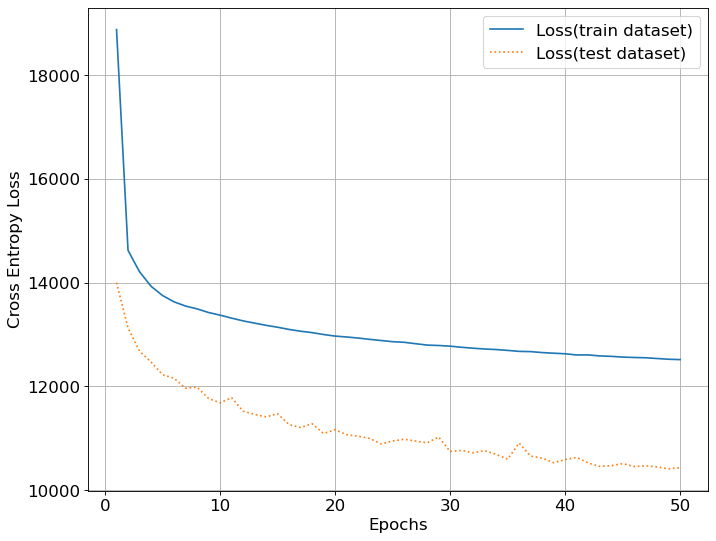

In [47]:
torch.save(model_VAE,os.path.join(data_loc_ex78,'exercise_VAE.ptg'))
plt.figure(figsize=(10,8),dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
plt.plot(range(1,no_epochs+1),loss_epoch,label='Loss(train dataset)',linestyle='-')
plt.plot(range(1,no_epochs+1),loss_epoch_test,label='Loss(test dataset)',linestyle=':')
plt.legend(loc=1,prop={'size': 15})
plt.xlabel("Epochs",fontdict={'size':15})
plt.ylabel("Cross Entropy Loss",fontdict={'size':15})

plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
# plt.savefig(os.path.join(fig_path,"Exercise4_loss.png"),dpi=80,bbox_inches='tight')
plt.show()

In [35]:
import numpy as np
from torchvision.transforms import functional as TF
data_loc_ex78
def plot(ax,clean_image,output_image,labels,n_ros=2,n_cols=10):
    for i in range(n_cols):
        label=labels[i]
        ax[0][i].imshow(clean_image[i])
        ax[1][i].imshow(output_image[i])
        # ax[0][i].set_title(f"clean{label}")
        # ax[1][i].set_title(f"generated{label}")
        ax[0][i].axis("off")
        ax[1][i].axis("off")
model_VAE = torch.load(data_loc_ex78+'\exercise_VAE.ptg')
model_VAE.eval()
mu,Std,DE,x_output_example = model_VAE(x_clean_example).to(device)
fig=plt.figure(figsize=(10*3,2*3))
ax=fig.subplots(2,10)
plot(ax,x_clean_example.permute(0,2,3,1).numpy().squeeze(),x_output_example.cpu().detach().permute(0,2,3,1).numpy().squeeze(),labels_example,2,10)

RuntimeError: Tensor for argument #1 'input' is on CPU, Tensor for argument #2 'output' is on CPU, but expected them to be on GPU (while checking arguments for slow_conv_transpose2d_out_cuda)

c:\Users\hanba\anaconda3\envs\tensorflow\lib\site-packages\torch\nn\functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

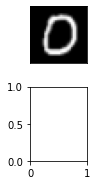

In [36]:
import numpy as np
data_loc_ex78

model_VAE = torch.load(data_loc_ex78+'\exercise_VAE.ptg')
model_VAE.eval()
mu,Std,DE,x_output_example = model_VAE(x_clean_example.to(device))
# type(model_VAE(x_clean_example))
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_output_example[i,0,:,:].detach().numpy(),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

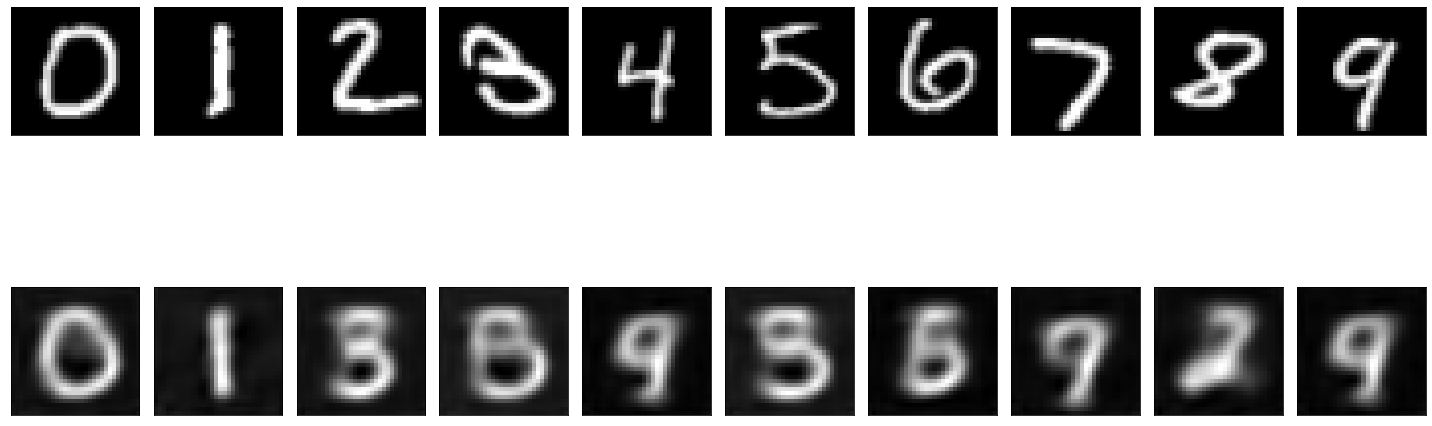

In [48]:
# model_VAE = torch.load(os.path.join(model_loc,"exercise_VAE.ptg"))

examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
with torch.no_grad():
    mu,log_var,fc1,output_VAE = model_VAE(x_clean_example.to(device))

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,10,i+11)
    plt.imshow(output_VAE[i,0,:,:].cpu(),cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
fig_path = os.path.join(os.path.abspath("."),"figure")
# plt.savefig(os.path.join(fig_path,"exercise_VAE_examples.png"),dpi=80,bbox_inches='tight')
plt.show()

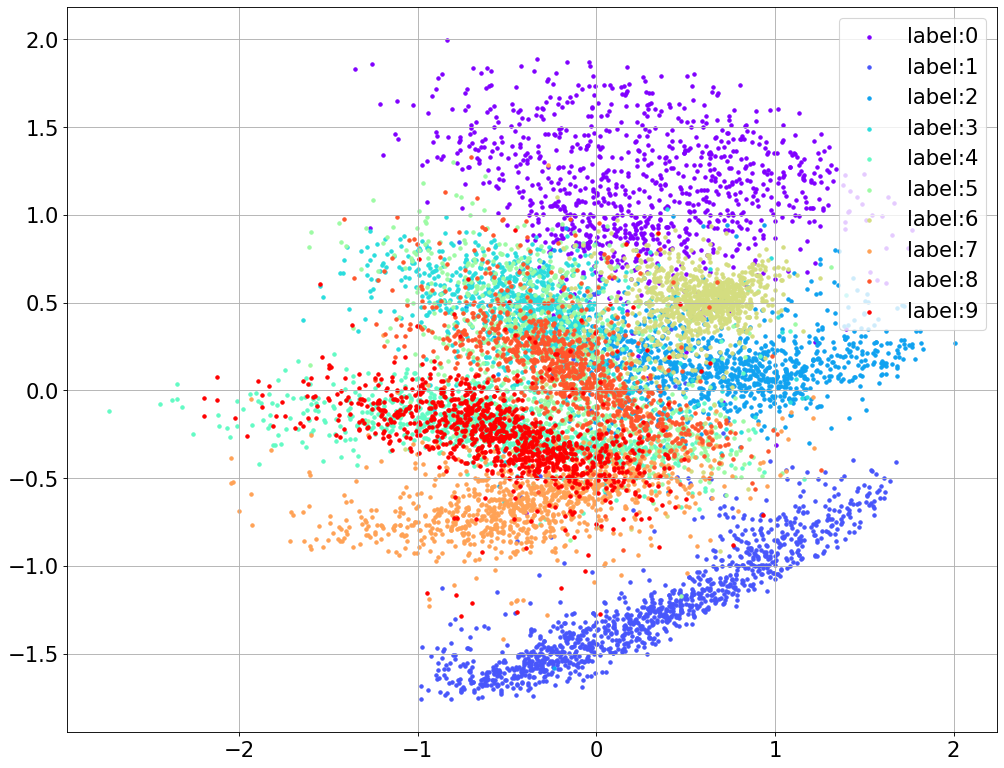

In [49]:
model_VAE.eval()
with torch.no_grad():
    mu,log_var,fc1,outputs = model_VAE(x_clean_test.to(device))

import matplotlib.cm as cm
import numpy as np

colors = cm.rainbow(np.linspace(0, 1,10))
plt.figure(figsize=(15,12),dpi=80, facecolor='w', edgecolor='k')
for i in range(10):
    c = colors[i]
    latent_c = mu[torch.where(labels_test==i)]
    # if i == 3 or i==6:
    plt.scatter(latent_c[:,0].cpu(), latent_c[:,1].cpu(), color=c,label=f"label:{i}",marker='.')

plt.xticks(size=19)
plt.yticks(size=19)
plt.legend(loc=1,prop={'size': 19})
plt.grid()
# plt.savefig(os.path.join(fig_path,"Exercise_VAE_scatter.png"),dpi=80,bbox_inches='tight')
plt.show()

## 15 grid for result


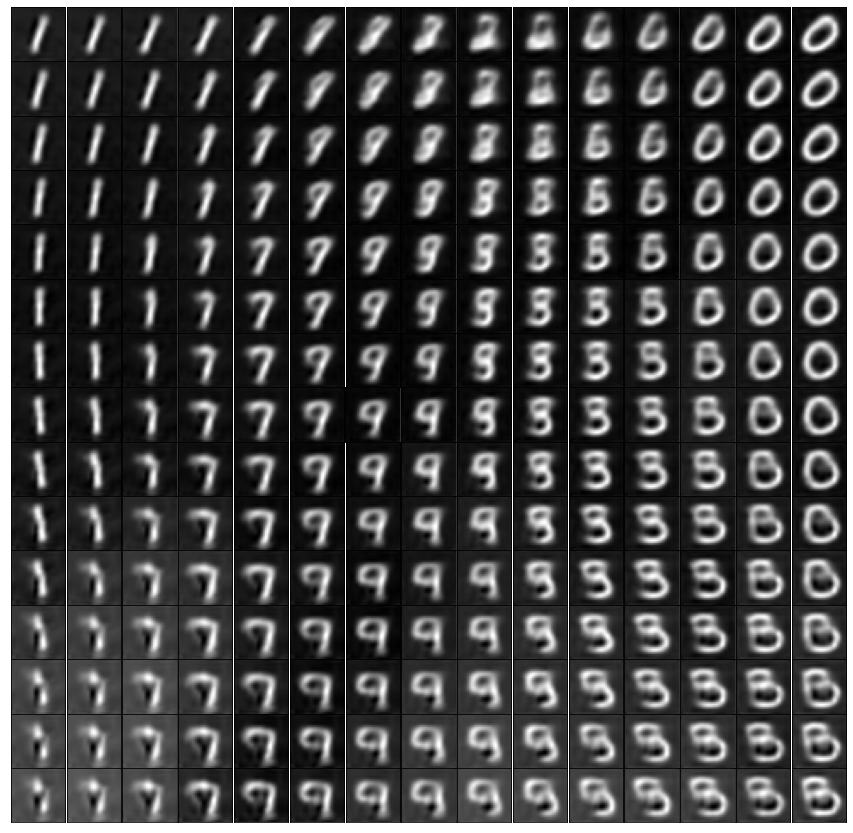

In [50]:
x = torch.arange(-2,1,3/15)
y = torch.arange(-1.5,1.5,3/15)
latent_VAE = torch.zeros((15*15,2),requires_grad=False)
for i in range(15):
    for j in range(15):
        latent_VAE[i*15+j,:] = torch.Tensor([x[i],y[j]])

with torch.no_grad():
    _,output_VAE = model_VAE.decoder(latent_VAE.to(device))


plt.figure(figsize=(15,15))
for i in range(15):
    for j in range(15):
        plt.subplot(15,15,i*15+j+1)
        plt.imshow(output_VAE[(14-i)*15+j,0,:,:].cpu(),cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.subplots_adjust(wspace=0,hspace=0)
fig_path = os.path.join(os.path.abspath("."),"figure")
# plt.savefig(os.path.join(fig_path,"exercise5_VAE.png"),dpi=80,bbox_inches='tight')
plt.show()